## Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score,precision_recall_curve, average_precision_score,recall_score, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold,train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import numpy as np
import yaml
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Class_Object

In [2]:
label_mapping = {
    50: "Urban/Built up",
    80: "Fresh water",
    40: "Cultivated Area",
    124: "Open forest"
}


___

## Main Functions

In [3]:
def load_data(fileName):
    return pd.read_csv(fileName)

def preprocess_data(dataset):

    label_mapping = {
        50: "Urban/Built up",
        80: "Fresh water",
        40: "Cultivated Area",
        124: "Open forest"
    }
    
    dataset.drop(columns=['...1','longitude','latitude'],inplace=True)
    X = dataset.drop(columns=['Label'])
    y = dataset['Label']
    ### Normalizing features and Splitting the dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def exploratory_data_analysis(df):
    
    plt.figure(figsize=(10, 6))
    label_counts = df['Label'].value_counts()
    label_counts.plot(kind='bar', color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Selected Labels (40, 80, 50, 124)')
    plt.show()


    # Plot a pie chart showing the percentage of each class
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'orange', 'green', 'red'], startangle=90)
    plt.ylabel('')
    plt.title('Percentage Distribution of Selected Labels (40, 80, 50, 124)')
    plt.show()
    
    # Correlation heatmap to understand relationships between features
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.show()

    VIF = pd.DataFrame()
    VIF["variables"] = df.columns
    VIF["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    print(VIF)
    
def tune_and_evaluate_models(model, X_train, X_test, y_train, y_test):
    param_grids = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42),
            'params': {'C': [0.01, 0.1, 1, 10, 100]}
        },
        'Decision Tree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10]}
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7, None]}
        },
        'Gradient Boosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
        },
        'Support Vector Machine': {
            'model': SVC(probability=True, random_state=42),
            'params': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
        },
        'Neural Network': {
            'model': MLPClassifier(max_iter=1000, random_state=42),
            'params': {'hidden_layer_sizes': [(50,), (100,), (150,)], 'learning_rate_init': [0.001, 0.01, 0.1]}
        }
    }
    
    label_mapping = {
        50: "Urban/Built up",
        80: "Fresh water",
        40: "Cultivated Area",
        124: "Open forest"
    }
    
    classes = np.unique(y_train)
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_train_bin.shape[1]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    model_data = param_grids[model]
    # Hyperparameter Tuning
    grid_search = GridSearchCV(
        model_data['model'],
        model_data['params'],
        cv=kf,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Cross-Validation
    cv_scores = cross_val_score(
        best_model,
        X_train,
        y_train,
        cv=kf,
        scoring='accuracy'
    )
    print(f'{model} Cross-Validation Accuracy: {np.mean(cv_scores):.2f} (+/- {np.std(cv_scores):.2f})')

    # Model Evaluation
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Print metrics and save confusion matrix
    print(f'{model} (Best Hyperparameters: {grid_search.best_params_})')
    print(f'Accuracy: {acc:.2f}')
    print(f'Precision: {precision:.2f}, Recall: {recall:.2f}')
    print(f'Classification Report for {model}:\n{classification_report(y_test, y_pred)}\n')

    # Save Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=best_model.classes_,
        yticklabels=best_model.classes_
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    textstr = f'Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}'
    plt.title(f'Confusion Matrix for {model}\n{textstr}')
    plt.savefig(f'images/confusion_matrix_{model}.png')
    plt.show()
    plt.close()

    # Precision-Recall Curve
    if hasattr(best_model, 'predict_proba'):
        y_score = best_model.predict_proba(X_test)
    else:
        y_score = best_model.decision_function(X_test)
        if y_score.ndim == 1:
            y_score = np.vstack([-y_score, y_score]).T

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
        plt.plot(
            recall_curve,
            precision_curve,
            lw=2,
            label=f'{classes[i]}: {label_mapping[classes[i]]} (AP = {average_precision:.2f})'
        )

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model} (Tuned)')
    plt.legend(loc='lower left')
    plt.savefig(f'images/precision_recall_curve_{model}.png')
    plt.show()
    plt.close()


## Read the dataset and select only the classes of interest.

In [4]:

file_path = 'dataset/LULC_Dataset.csv'
dataset = load_data(file_path)
dataset = dataset[dataset['Label'].isin([40, 80, 50, 124])]
dataset.head()

,...1,B11_SWIR1,B12_SWIR2,B2_Blue,B3_Green,B4_Red,B8_NIR,Label,NDVI,NDWI,longitude,latitude
1,1,2969.0,1959.0,1209.0,1256.0,1363.0,2679.0,40,0.325581,-0.361626,13.572432,-9.018050
3,3,2741.0,1670.0,1336.0,1207.0,1198.0,2202.0,40,0.295294,-0.291874,13.608154,-9.017615
8,8,1609.0,798.0,1273.0,1045.0,866.0,1820.0,124,0.355175,-0.270506,13.971227,-8.871898
9,9,1735.0,821.0,1145.0,955.0,726.0,2366.0,124,0.530401,-0.424872,13.904581,-8.925303
11,11,217.0,134.0,1263.0,980.0,758.0,585.0,80,-0.128816,0.252396,13.939900,-8.972945


## Preprocessing

In [5]:
X_train, X_test, y_train, y_test = preprocess_data(dataset)# will also remove any noisy

## EDA

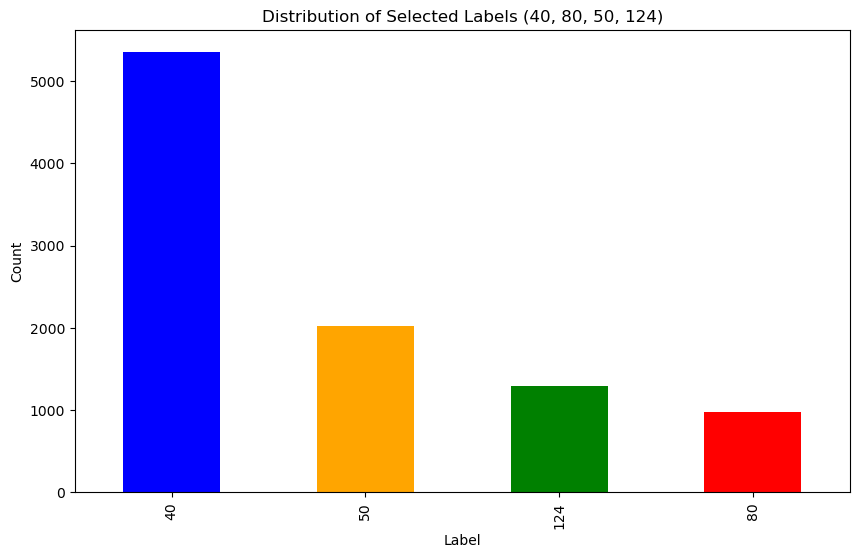

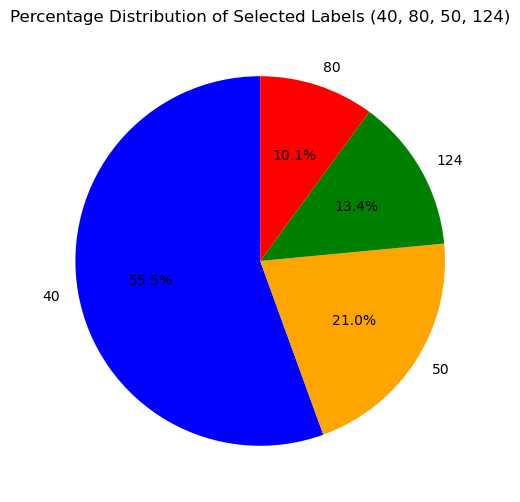

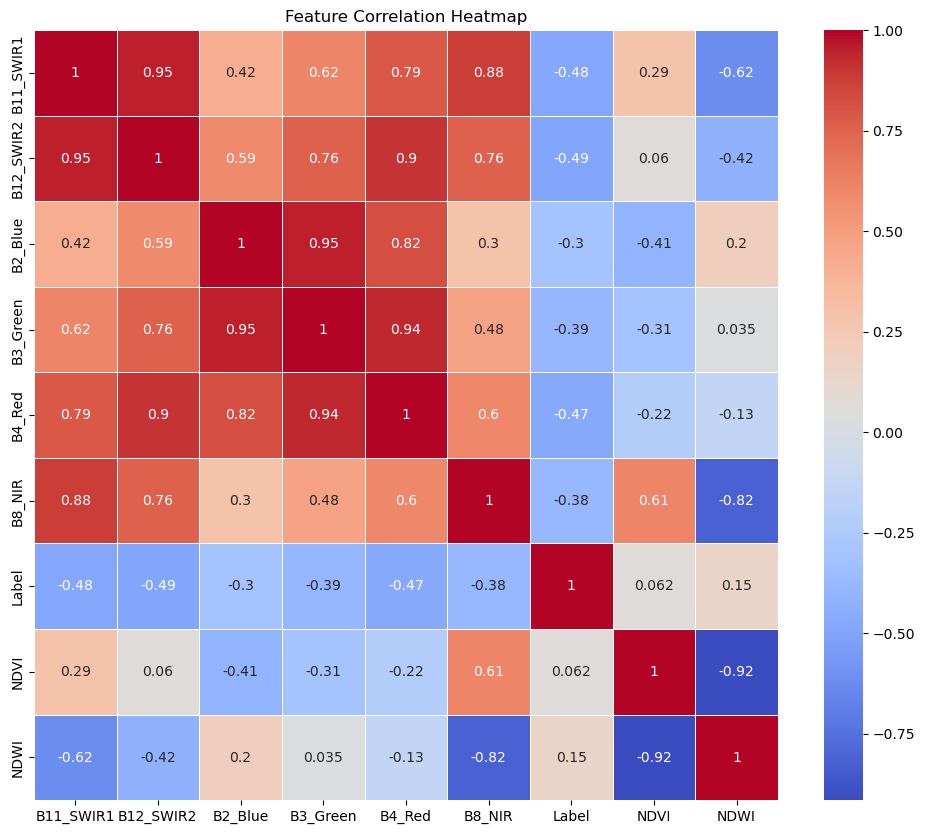

   variables          VIF
0  B11_SWIR1   317.504763
1  B12_SWIR2   237.885160
2    B2_Blue   475.191852
3   B3_Green  2007.629858
4     B4_Red  1767.270753
5     B8_NIR   429.198591
6      Label     7.712714
7       NDVI   569.600544
8       NDWI   473.047612


In [6]:
exploratory_data_analysis(dataset)

## Run the first Model Logistic Regression

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/ezequielmussambe/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ezequielmussambe/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Logistic Regression Cross-Validation Accuracy: 0.89 (+/- 0.01)
Logistic Regression (Best Hyperparameters: {'C': 10})
Accuracy: 0.88
Precision: 0.87, Recall: 0.88
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          40       0.86      0.93      0.89      1042
          50       0.90      0.89      0.89       400
          80       1.00      1.00      1.00       213
         124       0.81      0.58      0.68       273

    accuracy                           0.88      1928
   macro avg       0.89      0.85      0.86      1928
weighted avg       0.87      0.88      0.87      1928




/Users/ezequielmussambe/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ezequielmussambe/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

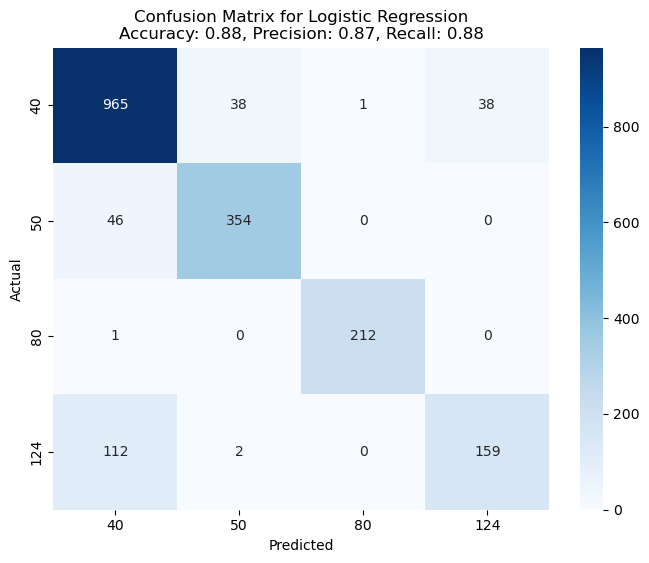

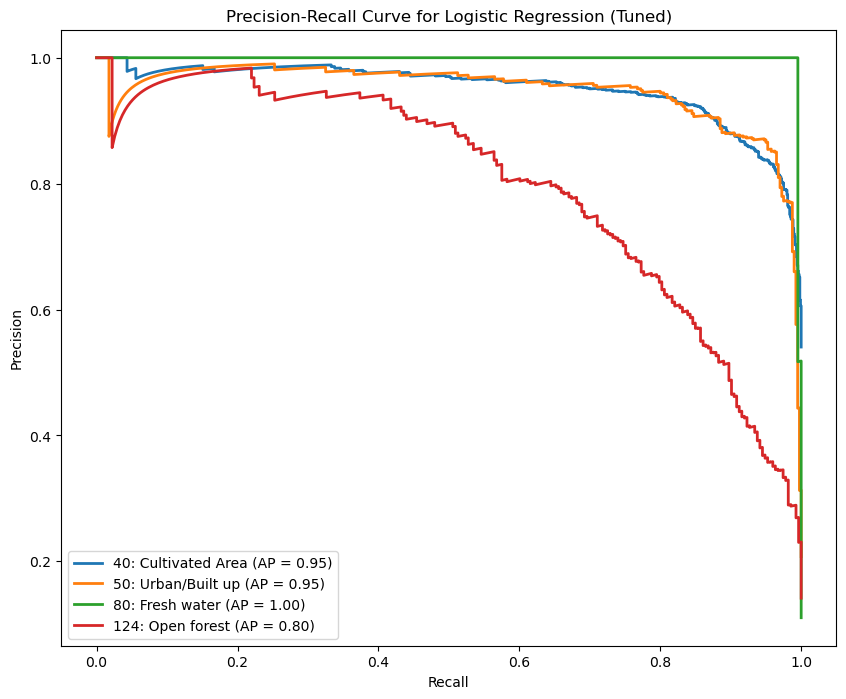

In [7]:
tune_and_evaluate_models("Logistic Regression",X_train, X_test, y_train, y_test)

## Run the second Model Decision Tree

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Decision Tree Cross-Validation Accuracy: 0.88 (+/- 0.01)
Decision Tree (Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 10})
Accuracy: 0.88
Precision: 0.88, Recall: 0.88
Classification Report for Decision Tree:
              precision    recall  f1-score   support

          40       0.88      0.92      0.90      1042
          50       0.87      0.92      0.89       400
          80       1.00      0.99      1.00       213
         124       0.84      0.63      0.72       273

    accuracy                           0.88      1928
   macro avg       0.89      0.86      0.88      1928
weighted avg       0.88      0.88      0.88      1928




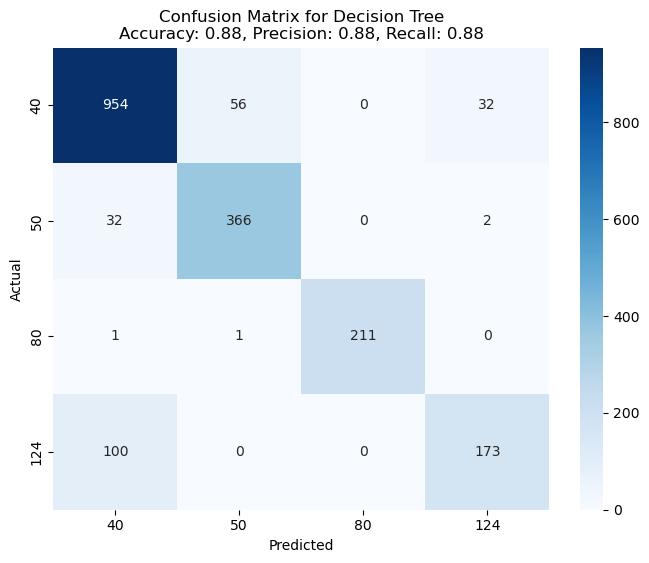

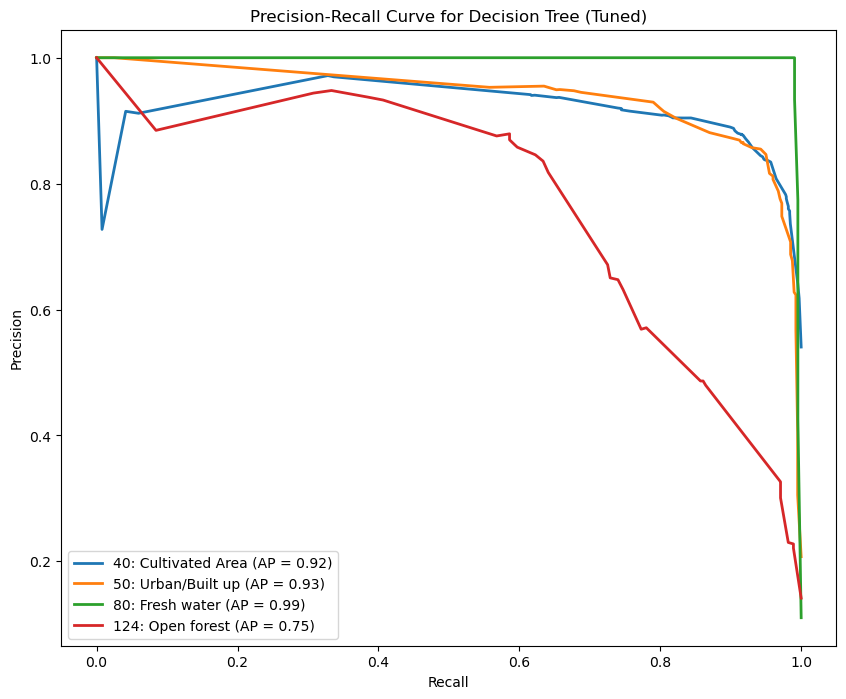

In [8]:
tune_and_evaluate_models("Decision Tree",X_train, X_test, y_train, y_test)

## Run the third Model Random Forest

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest Cross-Validation Accuracy: 0.90 (+/- 0.01)
Random Forest (Best Hyperparameters: {'max_depth': None, 'n_estimators': 100})
Accuracy: 0.90
Precision: 0.90, Recall: 0.90
Classification Report for Random Forest:
              precision    recall  f1-score   support

          40       0.89      0.93      0.91      1042
          50       0.92      0.93      0.92       400
          80       1.00      1.00      1.00       213
         124       0.83      0.69      0.76       273

    accuracy                           0.90      1928
   macro avg       0.91      0.89      0.90      1928
weighted avg       0.90      0.90      0.90      1928




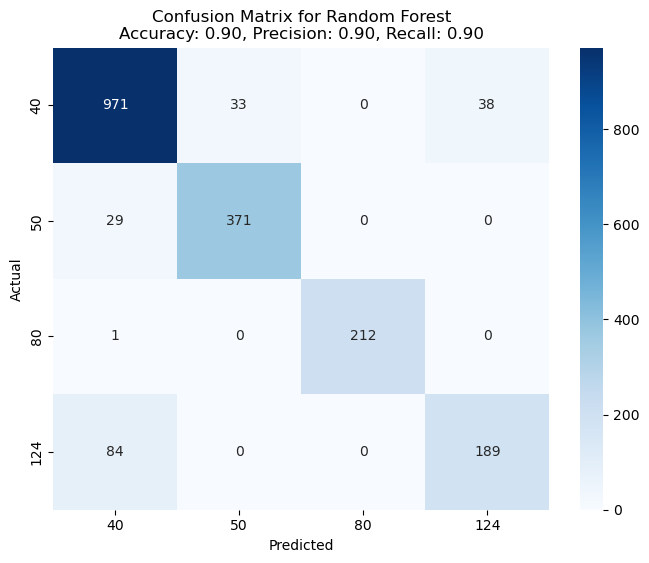

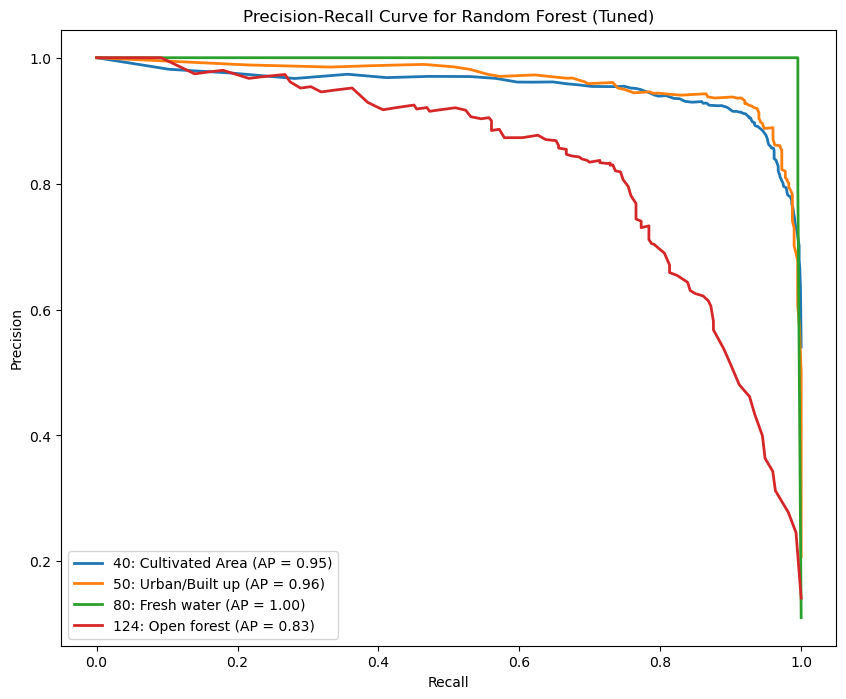

In [9]:
tune_and_evaluate_models("Random Forest",X_train, X_test, y_train, y_test)

## Run the fourth ModelGradient Boosting

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Gradient Boosting Cross-Validation Accuracy: 0.90 (+/- 0.01)
Gradient Boosting (Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150})
Accuracy: 0.90
Precision: 0.90, Recall: 0.90
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

          40       0.90      0.93      0.91      1042
          50       0.90      0.93      0.91       400
          80       0.99      1.00      0.99       213
         124       0.85      0.71      0.78       273

    accuracy                           0.90      1928
   macro avg       0.91      0.89      0.90      1928
weighted avg       0.90      0.90      0.90      1928




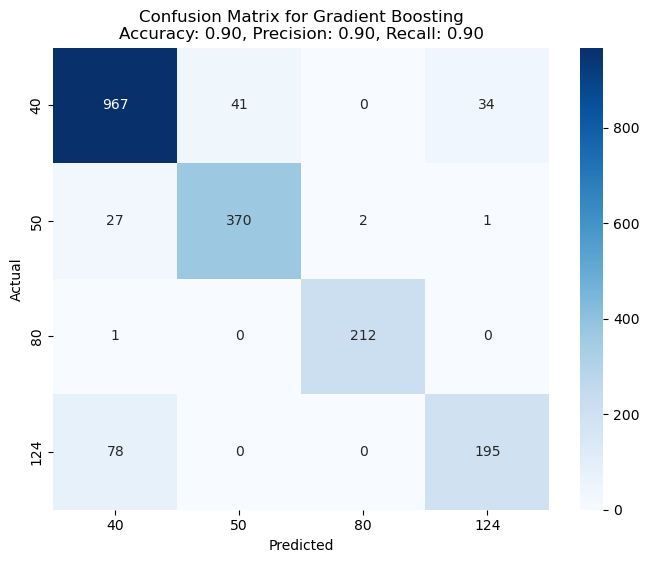

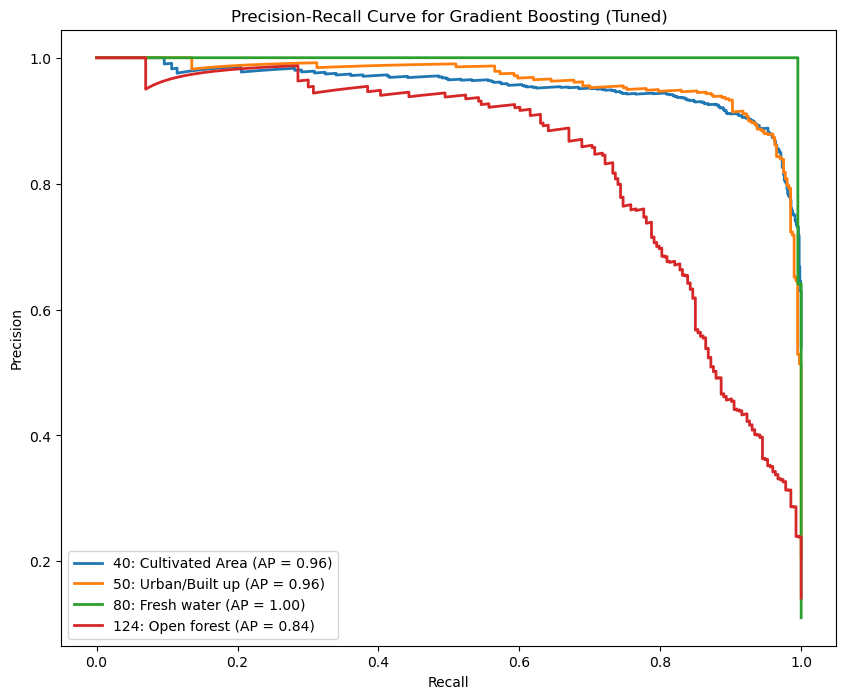

In [10]:
tune_and_evaluate_models("Gradient Boosting",X_train, X_test, y_train, y_test)

## Run the fifth Support Vector Machine

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Support Vector Machine Cross-Validation Accuracy: 0.90 (+/- 0.01)
Support Vector Machine (Best Hyperparameters: {'C': 100, 'kernel': 'rbf'})
Accuracy: 0.90
Precision: 0.90, Recall: 0.90
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

          40       0.89      0.93      0.91      1042
          50       0.91      0.93      0.92       400
          80       1.00      0.99      1.00       213
         124       0.83      0.67      0.74       273

    accuracy                           0.90      1928
   macro avg       0.91      0.88      0.89      1928
weighted avg       0.90      0.90      0.90      1928




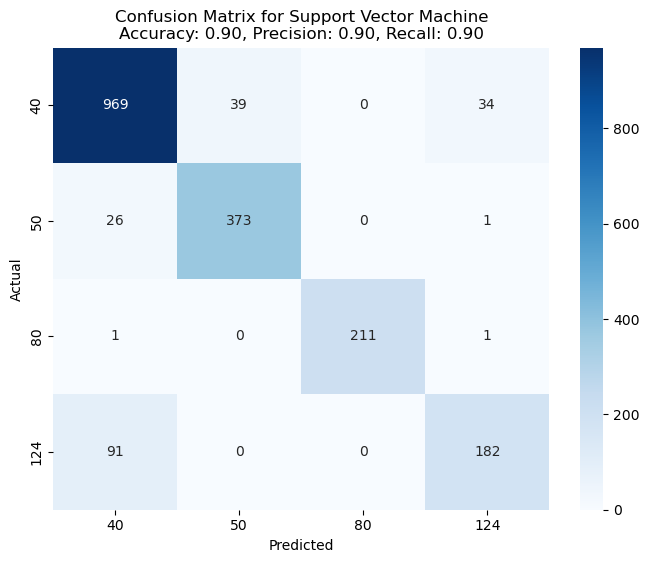

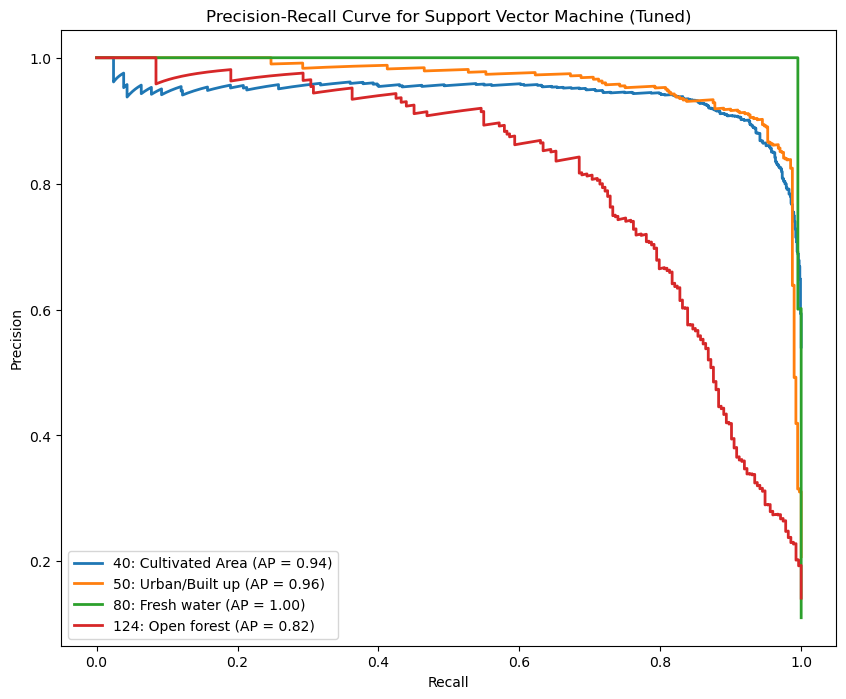

In [11]:
tune_and_evaluate_models("Support Vector Machine",X_train, X_test, y_train, y_test)

## Run the sixth Neural Network

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Neural Network Cross-Validation Accuracy: 0.91 (+/- 0.01)
Neural Network (Best Hyperparameters: {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001})
Accuracy: 0.90
Precision: 0.90, Recall: 0.90
Classification Report for Neural Network:
              precision    recall  f1-score   support

          40       0.90      0.93      0.91      1042
          50       0.90      0.92      0.91       400
          80       1.00      1.00      1.00       213
         124       0.83      0.71      0.76       273

    accuracy                           0.90      1928
   macro avg       0.91      0.89      0.90      1928
weighted avg       0.90      0.90      0.90      1928




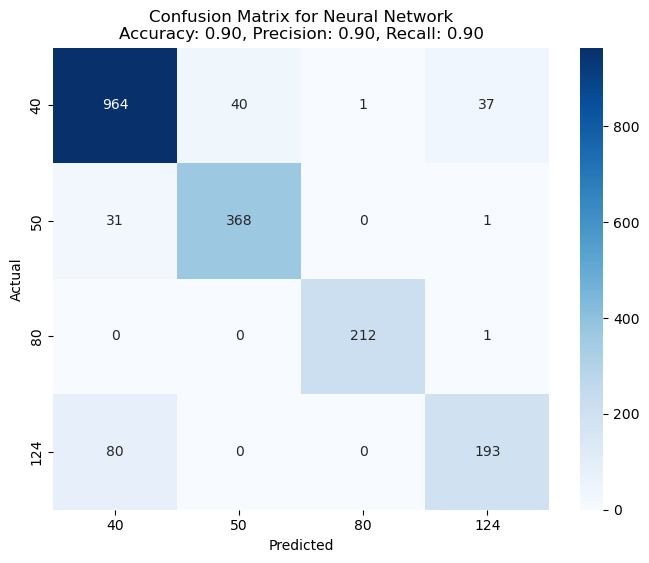

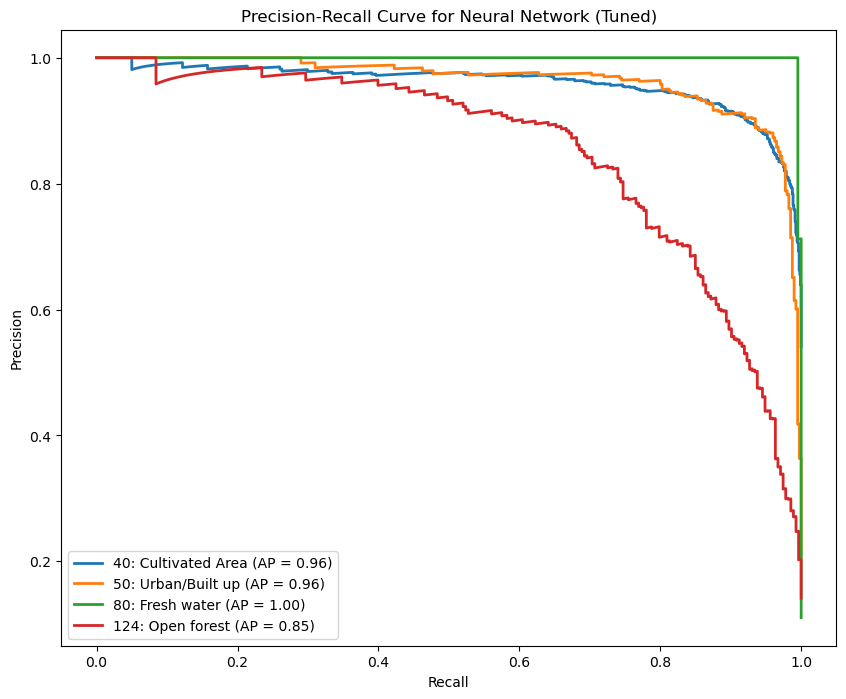

In [12]:
tune_and_evaluate_models("Neural Network",X_train, X_test, y_train, y_test)

## END!!!